<a href="https://colab.research.google.com/github/llfabbri/Resnet_V2/blob/main/Resnet101%2Bcos_sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!git clone https://github.com/GiovasGit/competition_code.git

Cloning into 'competition_code'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 50 (delta 9), reused 34 (delta 0), pack-reused 0
Unpacking objects: 100% (50/50), 99.09 KiB | 5.83 MiB/s, done.


In [20]:
#NETWORK FILE
import torchvision
import torchvision.models as models
import torch

class ResNet(torch.nn.Module):

    """Definition of a pretrained ResNet to compute features.
    This won't have a final layer sending to classes, the
    final layer will be an identity layer outputting the
    features of the next-to-last layer. Its configuration
    won't have num_classes"""

    def __init__(self, config):
        super(ResNet, self).__init__()
        # Load a resnet18 from torchvision, either use pretrained weights or not
        #MAYBE WE COULD MAKE A COMPARISON WITH A NON PRETRAINED
        weights = "IMAGENET1K_V2" if config["pretrained"] else None
        self.net = models.resnet101(weights=weights)
        # remove the last FC layer
        #num_output_feats = self.net.fc.in_features   # dim  of the feature, I DON'T THINK WE NEED THIS
        self.net.fc = torch.nn.Identity()

    def forward(self, x):
        features = self.net(x)
        return features

In [21]:
#dataset file
import torch
import torchvision.transforms as transforms
import PIL.Image as Image
import glob, os
import numpy as np


class Query_Images(torch.utils.data.Dataset):

    """create a Dataset class which returns the same image,
    len of instances and returns the same image in getitem.
    NO AUGMENTATION BECAUSE THIS GOES FOR TESTING"""

    def __init__(self, root: str, transform = None):
        self.root = root
        self.transform = transform
        self.image_paths = sorted(glob.glob(os.path.join(self.root, "*.jpg")))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx: int):
        image_path = self.image_paths[idx]
        image_name = os.path.basename(image_path)
        image = Image.open(image_path).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)

        return image, image_name


def get_query_dataset(config):

    """define transformations and instantiate
    the dataset class  with transformations."""

    # Define the transformations at test time
    #transform_rgb = transforms.Lambda(lambda image: image.convert('RGB')) SHOULD NOT BE NECESSARY, RIGHT?
    transform = transforms.Compose([
        #transform_rgb,
        transforms.ToTensor(),
        transforms.Normalize(mean=[0], std=[1]),
        transforms.Resize((224, 224)) #cropping not needed
    ])

    query = Query_Images(root = config["dataset_query"]["data_root_query"], transform = transform)

    # instantiate DataLoader:
    query_dataloader = torch.utils.data.DataLoader(query, config["dataset_query"]["batch_size_query"], shuffle = False)

    return query_dataloader

class Gallery_Images(torch.utils.data.Dataset): #see lab02 for transformations

    """create a Dataset class which returns the same image,
    len of instances, and returns the same image in getitem.
    NO AUGMENTATION BECAUSE THIS GOES FOR TESTING"""

    def __init__(self, root: str, transform = None):
        self.root = root
        self.transform = transform
        self.image_paths = sorted(glob.glob(os.path.join(self.root, "*.jpg")))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx: int):
        image_path = self.image_paths[idx]
        image_name = os.path.basename(image_path)
        image = Image.open(image_path).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)

        return image, image_name


def get_gallery_dataset(config):

    """define transformations and instantiate
    the dataset class  with transformations."""

    # Define the transformations at test time
    #transform_rgb = transforms.Lambda(lambda image: image.convert('RGB')) SHOULD NOT BE NECESSARY, RIGHT?
    transform = transforms.Compose([
        #transform_rgb,
        transforms.ToTensor(),
        transforms.Normalize(mean=[0], std=[1]),
        transforms.Resize((224, 224)) #cropping not needed
    ])

    gallery = Gallery_Images(root = config["dataset_gallery"]["data_root_gallery"], transform = transform)

    # instantiate DataLoader:
    gallery_dataloader = torch.utils.data.DataLoader(gallery, config["dataset_gallery"]["batch_size_gallery"], shuffle = False)

    return gallery_dataloader

In [23]:
#test file
import argparse
import yaml
import os
from http.client import responses
from pathlib import Path

import requests
import json
import torch
import torch.nn.functional as F

#from dataset import get_query_dataset, get_gallery_dataset
#from network import ResNet
def test(net, q_loader, g_loader):
    with torch.no_grad():
        my_dict_q = dict()
        counter_q = 1

        for q_batch, q_filenames in q_loader:
            q_batch = q_batch.cuda()
            q_outputs = net(q_batch)  # (q_batch_size, 512)
            q_name_str = str(q_filenames[0])
            my_dict_q[q_name_str] = q_outputs
            if counter_q != len(q_loader):
                print("added the number", counter_q, "element to the query dictionary")
                counter_q += 1
            else:
                print("The query dictionary is fully completed. Start with the gallery dictionary.")

        my_dict_g = dict()
        counter_g = 1

        for g_batch, g_filenames in g_loader:
            g_batch = g_batch.cuda()
            g_outputs = net(g_batch)  # (g_batch_size, 512)
            g_name_str = str(g_filenames[0])
            my_dict_g[g_name_str] = g_outputs
            if counter_g != len(g_loader):
                print("added the number", counter_g, "element to the gallery dictionary")
                counter_g += 1
            else:
                print("The gallery dictionary is fully completed.")

        intermediate_dict = dict()
        last_counter = 1

        for key_q, value_q in my_dict_q.items():
            val = []  # Create a new list for each query image
            for key_g, value_g in my_dict_g.items():
                val.append((F.cosine_similarity(value_q, value_g), key_g))

            val.sort(key=lambda x: x[0], reverse=True)  # sorting values based on distances #reverse=True for cosine similarity
            intermediate_dict[key_q] = val
            if last_counter != len(q_loader):
                print("added the number", last_counter, "element to the intermediate dictionary")
                last_counter += 1
            else:
                print("the intermediate dictionary is fully completed")

        return intermediate_dict


def top_k(dictionary: dict, k: int):
    finaldict = dict()

    for key, values in dictionary.items():
        values.sort(key=lambda x: x[0], reverse=True)  # Sort gallery images based on cosine similarity
        finallist = [value[1] for value in values[:k]]  # Extract the gallery images up to k
        finaldict[key] = finallist

    if 'group name' in finaldict:
        del finaldict['group name']  # Remove the 'group name' key from the dictionary

    return finaldict


def submit(final, url="https://competition-production.up.railway.app/results/"):
    res = json.dumps(final)
    print(res)
    response = requests.post(url, res)
    try:
        result = json.loads(response.text)
        print(f"accuracy is {result['results']}")
    except json.JSONDecodeError:
        print(f"ERROR: {response.text}")
        return None

if __name__ == "__main__":

    config_path = "/content/competition_code/config"  # Replace with the actual configuration file path

    # Load the configuration file
    path = Path(config_path)
    actual_config_path = path / "resnet101_inet1k_init.yaml"
    with open(actual_config_path, "r") as f:
        config = yaml.safe_load(f)
        print(f"\tConfiguration file loaded from: {actual_config_path}")

    query_dataloader = get_query_dataset(config)
    gallery_dataloader = get_gallery_dataset(config)

    model = ResNet(config['model'])
    model.cuda()

    results = test(model, query_dataloader, gallery_dataloader)
    mydata = dict()
    mydata['groupname'] = "The Diamond Tip"
    mydata['images'] = top_k(results, 10)
    print(mydata)
    submit(mydata)
 


Output streaming troncato alle ultime 5000 righe.
added the number 1496 element to the gallery dictionary
added the number 1497 element to the gallery dictionary
added the number 1498 element to the gallery dictionary
added the number 1499 element to the gallery dictionary
added the number 1500 element to the gallery dictionary
added the number 1501 element to the gallery dictionary
added the number 1502 element to the gallery dictionary
added the number 1503 element to the gallery dictionary
added the number 1504 element to the gallery dictionary
added the number 1505 element to the gallery dictionary
added the number 1506 element to the gallery dictionary
added the number 1507 element to the gallery dictionary
added the number 1508 element to the gallery dictionary
added the number 1509 element to the gallery dictionary
added the number 1510 element to the gallery dictionary
added the number 1511 element to the gallery dictionary
added the number 1512 element to the gallery dictionar

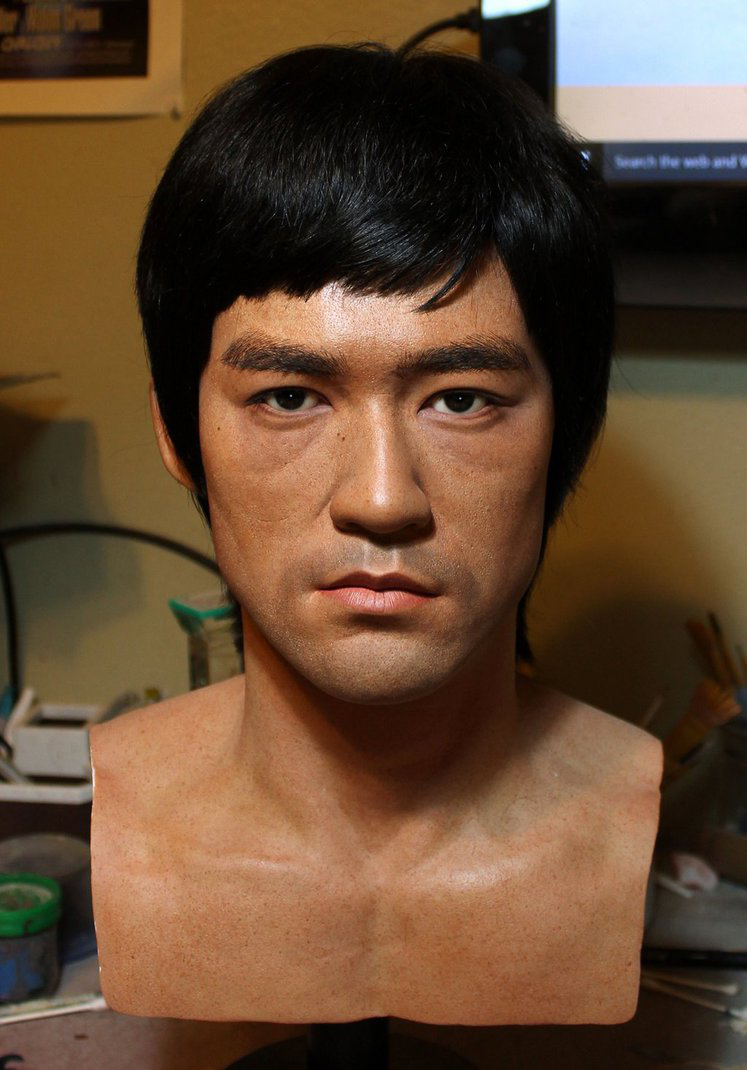

In [ ]:
from PIL import Image

# Specify the path to the image file
image_path = "/content/drive/MyDrive/gallery/f258206ba77009b151decc6ca9eada30f197118e.jpg"

# Open the image using PIL
image = Image.open(image_path)

# Print the image
image.show()